In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from formatting_data import get_data_frame, normalise
from numba import njit
from functions import reverse_normaliser
import textwrap

In [104]:
df, game_df = get_data_frame() #game_df used for identifying game using game_id
game_df.head(3)

,game_id,game_name
0,0,Counter-Strike
1,1,Team Fortress Classic
2,2,Day of Defeat


In [101]:
user0 = df.loc[df.user_id == 0].sort_values(by='playtime', ascending=False).head(10)[['game_id', 'playtime']]
user0_games = game_df.set_index(game_df.game_id).loc[user0.game_id, 'game_name']
playtimes = user0.playtime.apply(reverse_normaliser)

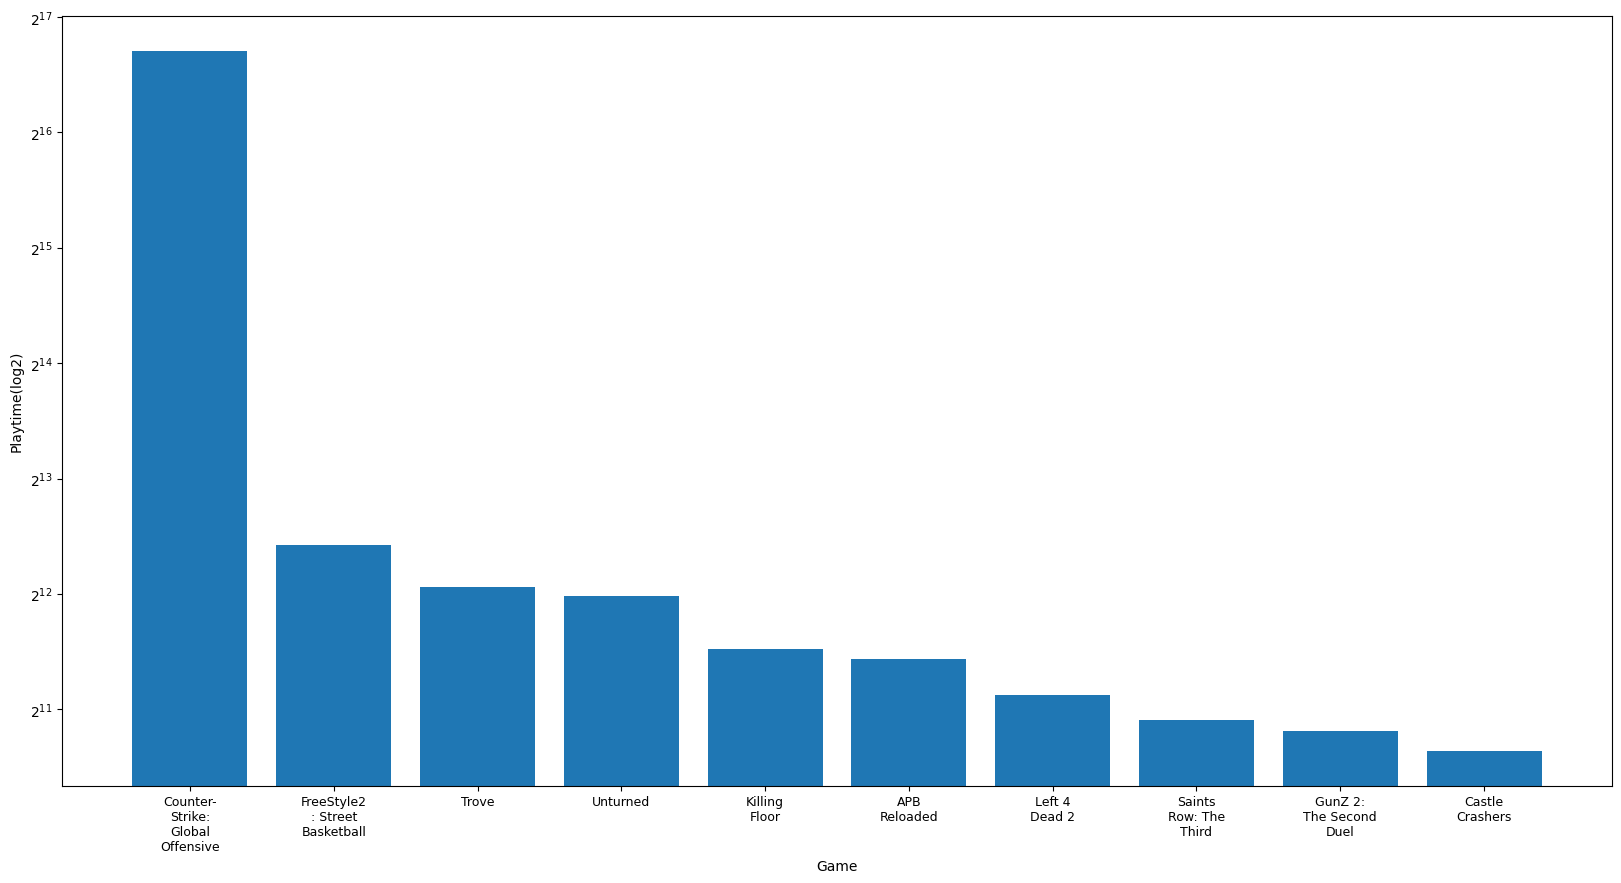

In [102]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar([textwrap.fill(label, 10) for label in user0_games[0:20]], playtimes[0:20])
ax.set_xlabel('Game')
ax.set_ylabel('Playtime(log2)')
ax.set_yscale('log', base=2)
ax.tick_params(axis='x', labelsize=9)
plt.show()
#BEWARE


In [108]:
#creating utility matrix
utility_matrix = df.pivot_table(index=df.columns[0], columns=df.columns[1], values=df.columns[2], fill_value=0)
utility_matrix = utility_matrix.to_numpy(dtype=np.float32)

In [109]:
#mean normalisation
mean_vector = utility_matrix.mean(axis=1)
utility_matrix = (utility_matrix.T - mean_vector)

In [110]:
num_features = 100

#initialising users and items features randomly
user_matrix = np.random.uniform(-1, 1, (utility_matrix.shape[0], num_features))
item_matrix = np.random.uniform(-1, 1, (utility_matrix.shape[1], num_features))
user_matrix = np.float32(user_matrix)
item_matrix = np.float32(item_matrix)

user_sqsum = np.sum(user_matrix ** 2)
item_sqsum = np.sum(item_matrix ** 2)

In [112]:
def cost(y, pred, normaliser, chunk_size=500, _lambda=1, alpha=61):
    cost = (user_sqsum + item_sqsum) * _lambda
    
    for i in range(0, y.shape[0], chunk_size):
        yhat_chunk = normaliser(pred[i:i+chunk_size], alpha)
        cost += np.sum(
                np.square(
                np.subtract(y[i:i+chunk_size], yhat_chunk)
            )
        )

    return cost/2
           

In [113]:
pred = user_matrix @ item_matrix.T